In [1]:
import numpy as np
import pandas as pd

In [2]:
listings = pd.read_csv('listings.csv')
review = pd.read_csv('reviews.csv')

/Users/shilpabhat/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
listings_filtered = listings[['id', 'host_is_superhost']]
reviews_filtered = review[['listing_id', 'comments']]
reviews_filtered = reviews_filtered.rename(columns = {'listing_id':'id'})

df = pd.merge(reviews_filtered, listings_filtered, on = 'id')
df['host_is_superhost'] = np.where(df['host_is_superhost'] == 't', 1, 0)
df.head()

,id,comments,host_is_superhost
0,2265,I stayed here during SXSW and had a really ple...,1
1,2265,"Great place, close enough to everything downto...",1
2,2265,We had a great time in Austin staying at Paddy...,1
3,2265,We had a great stay at Zen East for South By S...,1
4,2265,I arrived late in the evening so did not meet ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339643 entries, 0 to 339642
Data columns (total 3 columns):
id                   339643 non-null int64
comments             339424 non-null object
host_is_superhost    339643 non-null int64
dtypes: int64(2), object(1)
memory usage: 10.4+ MB


In [6]:
df = df[df['id'].isin(df['id'].value_counts().reset_index(name="count").query("count > 250")["index"].to_list())]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60337 entries, 33 to 317788
Data columns (total 3 columns):
id                   60337 non-null int64
comments             60309 non-null object
host_is_superhost    60337 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [8]:
df = df.dropna(axis=0, how='any')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60309 entries, 33 to 317788
Data columns (total 3 columns):
id                   60309 non-null int64
comments             60309 non-null object
host_is_superhost    60309 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


#### Removing anything apart from Letters

In [10]:
import re
df['comments_cleaned'] = [re.sub(r'http\S+', '', str(x)) for x in df['comments']]
df['comments_cleaned'] = [re.sub(r'[^A-Za-z]+', ' ', str(x)) for x in df['comments_cleaned']]
df['comments_cleaned'] = df['comments_cleaned'].map(lambda x: x if type(x)!=str else x.lower())

#### Removing Stopwords, Tokenizing and Lemmatizing

In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
nltk.download('wordnet')
def clean_comments(text):
    
    words = nltk.word_tokenize(text)
    
    stopwords_vocabulary = stopwords.words('english')
    moreTOExclue = ['austin']
    stopwords_vocabulary.extend(moreTOExclue)
    
    filtered_text = [word for word in words if word not in stopwords_vocabulary]

    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(token) for token in filtered_text]
    return lemmatized_text
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shilpabhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shilpabhat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
df['processed_comments'] = df['comments_cleaned'].apply(clean_comments)

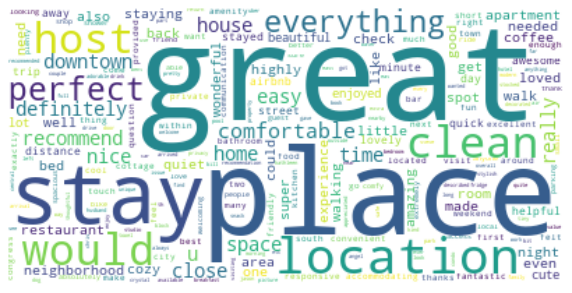

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# split sentences to get individual words
words = []
for line in df['processed_comments']: 
    words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color ='white',
    max_words = 2000,
    stopwords = stopwords.words('english')
   ).generate_from_frequencies(wordfreq)
plt.figure(figsize = (10,9))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Topic Modelling

In [14]:
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(df['processed_comments'])

In [15]:
texts = df['processed_comments']
corpus = [dictionary.doc2bow(text) for text in texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = dictionary, num_topics = 10, passes = 20)

In [16]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
visual = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
visual

/Users/shilpabhat/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.159571 -0.104826       1        1  21.520634
3     -0.192804  0.106430       2        1  15.329139
2      0.009808 -0.190909       3        1  13.523491
9     -0.105559 -0.107985       4        1  10.612206
8     -0.015502 -0.229369       5        1   9.619139
5     -0.071174  0.175329       6        1   9.034266
7     -0.159791  0.055422       7        1   8.851102
6     -0.034040  0.245036       8        1   7.300201
1      0.350706 -0.042664       9        1   2.407944
0      0.377926  0.093536      10        1   1.801882, topic_info=    Category          Freq   Term         Total  loglift  logprob
71   Default  42687.000000  great  42687.000000  30.0000  30.0000
211  Default   8371.000000   well   8371.000000  29.0000  29.0000
79   Default  33026.000000   stay  33026.000000  28.0000  28.0000
76   Default  38193.000000  place  38193.000000  27.0000  27.0000
493  Default   7597.000000  check   7597.000000  26.0000  26.0000
..       ...           ...    ...           ...      ...      ...
559  Topic10    352.098938   heat    519.467102   3.6274  -4.3162
678  Topic10    421.425323  dryer    686.880737   3.5278  -4.1365
37   Topic10    313.817322  texas    649.482483   3.2890  -4.4313
86   Topic10    197.287659      c    433.266022   3.2296  -4.8954
665  Topic10    169.061188     le    582.805420   2.7787  -5.0499

[621 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
15427      7  0.993062       aaron
230        1  0.996182    absolute
122        1  0.752035  absolutely
122        2  0.247890  absolutely
1442      10  0.998628          ac
...      ...       ...         ...
242        2  0.645299       would
242        3  0.014948       would
242        4  0.033429       would
242        5  0.060613       would
1247       6  0.997503      zilker

[994 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 10, 9, 6, 8, 7, 2, 1])

In [17]:
def evaluate_graph(dictionary, corpus, texts, limit):
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = gensim.models.ldamodel.CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

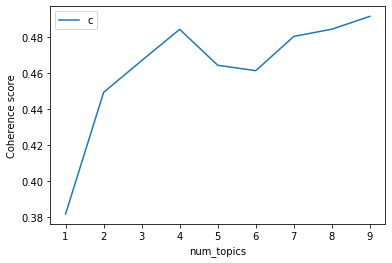

In [18]:
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=texts, limit=10)

##### Based on the graph, optimal number of topics for this dataset is 4

In [19]:
pyLDAvis.gensim.prepare(lmlist[3], corpus, dictionary)

/Users/shilpabhat/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.124371 -0.035372       1        1  28.538454
2      0.039918 -0.137615       2        1  26.243084
0     -0.080328  0.111831       3        1  25.681555
3      0.164780  0.061156       4        1  19.536907, topic_info=    Category          Freq         Term         Total  loglift  logprob
71   Default  45439.000000        great  45439.000000  30.0000  30.0000
95   Default  24184.000000     location  24184.000000  29.0000  29.0000
76   Default  40117.000000        place  40117.000000  28.0000  28.0000
103  Default  11470.000000    recommend  11470.000000  27.0000  27.0000
67   Default  10106.000000     downtown  10106.000000  26.0000  26.0000
..       ...           ...          ...           ...      ...      ...
65    Topic4   1506.250488        clean  19740.046875  -0.9402  -5.2462
211   Topic4   1227.356689         well   7673.482422  -0.2000  -5.4510
99    Topic4   1277.828247         nice  11939.933594  -0.6019  -5.4107
66    Topic4   1159.580566  comfortable  12443.222656  -0.7403  -5.5078
44    Topic4   1140.939575    apartment   8341.148438  -0.3565  -5.5240

[386 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
291       1  0.065056         access
291       2  0.030979         access
291       3  0.776692         access
291       4  0.127015         access
124       1  0.661533  accommodating
...     ...       ...            ...
242       4  0.090930          would
3562      2  0.990463             yo
3562      3  0.011005             yo
6219      1  0.973343           zero
6219      2  0.027810           zero

[942 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [20]:
lmlist[3].show_topics(formatted=False)

[(0,
  [('great', 0.045008253),
   ('location', 0.026239626),
   ('place', 0.025137011),
   ('downtown', 0.020680455),
   ('nice', 0.016305435),
   ('clean', 0.016245041),
   ('stay', 0.0151342675),
   ('close', 0.014650383),
   ('easy', 0.013606511),
   ('apartment', 0.0124570085)]),
 (1,
  [('great', 0.062496603),
   ('place', 0.055578493),
   ('stay', 0.049320888),
   ('location', 0.030573886),
   ('would', 0.027787011),
   ('clean', 0.023772987),
   ('recommend', 0.022329686),
   ('definitely', 0.019891998),
   ('host', 0.018072708),
   ('everything', 0.016815241)]),
 (2,
  [('home', 0.016346438),
   ('stay', 0.015154812),
   ('place', 0.014236549),
   ('u', 0.0106886225),
   ('touch', 0.0101317335),
   ('like', 0.009862911),
   ('beautiful', 0.009017938),
   ('space', 0.0088220285),
   ('back', 0.008514879),
   ('comfortable', 0.008198618)]),
 (3,
  [('night', 0.011277883),
   ('room', 0.010900091),
   ('house', 0.008542591),
   ('u', 0.00813174),
   ('bed', 0.008102112),
   ('sta

In [21]:
# print topic and words contributing to each topic
topics = lmlist[3].print_topics(num_words = 15)
for topic in topics:  
    print(topic)

(0, '0.045*"great" + 0.026*"location" + 0.025*"place" + 0.021*"downtown" + 0.016*"nice" + 0.016*"clean" + 0.015*"stay" + 0.015*"close" + 0.014*"easy" + 0.012*"apartment" + 0.012*"restaurant" + 0.011*"street" + 0.010*"walking" + 0.010*"comfortable" + 0.010*"good"')
(1, '0.062*"great" + 0.056*"place" + 0.049*"stay" + 0.031*"location" + 0.028*"would" + 0.024*"clean" + 0.022*"recommend" + 0.020*"definitely" + 0.018*"host" + 0.017*"everything" + 0.016*"perfect" + 0.013*"super" + 0.011*"highly" + 0.010*"comfortable" + 0.010*"space"')
(2, '0.016*"home" + 0.015*"stay" + 0.014*"place" + 0.011*"u" + 0.010*"touch" + 0.010*"like" + 0.009*"beautiful" + 0.009*"space" + 0.009*"back" + 0.008*"comfortable" + 0.008*"loved" + 0.008*"host" + 0.008*"well" + 0.007*"feel" + 0.007*"time"')
(3, '0.011*"night" + 0.011*"room" + 0.009*"house" + 0.008*"u" + 0.008*"bed" + 0.008*"stay" + 0.007*"nate" + 0.007*"place" + 0.007*"check" + 0.007*"one" + 0.006*"get" + 0.006*"also" + 0.005*"bathroom" + 0.005*"would" + 0.005

#### This is what the guests are mostly talking about their stay

* Topic 1: Location
* Topic 2: Overall - Stay, location, place, comfort, space, host
* Topic 3: space and comfort
* Topic 4: Particularly about room and stay

## Sentiment Analysis

In [22]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shilpabhat/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [23]:
# positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

#  neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [24]:
df['pos_sentiment_score'] = df['comments_cleaned'].apply(positive_score)
df['neg_sentiment_score'] = df['comments_cleaned'].apply(negative_score)
df['nue_sentiment_score'] = df['comments_cleaned'].apply(neutral_score)
df['compound_sentiment_score'] = df['comments_cleaned'].apply(compound_score)

In [25]:
def polarity_decode(text):
    if  analyzer.polarity_scores(text)['pos'] >= 0.5 : 
        value = 'Positive' 
    elif analyzer.polarity_scores(text)['neg'] >= 0.5 : 
        value =  "Negative"

    else : 
        value = "Neutral"
    return value

In [26]:
df['polarity_decode'] = df['comments_cleaned'].apply(polarity_decode)

In [27]:
df.head()

,id,comments,host_is_superhost,comments_cleaned,processed_comments,pos_sentiment_score,neg_sentiment_score,nue_sentiment_score,compound_sentiment_score,polarity_decode
33,5456,Sylvia is a hostess who is gracious and helpfu...,1,sylvia is a hostess who is gracious and helpfu...,"[sylvia, hostess, gracious, helpful, beyond, w...",0.179,0.0,0.821,0.9552,Neutral
34,5456,Highly recommended. Sylvia was extremely helpf...,1,highly recommended sylvia was extremely helpfu...,"[highly, recommended, sylvia, extremely, helpf...",0.309,0.0,0.691,0.8432,Neutral
35,5456,A great place to stay in a great city. Sylvia ...,1,a great place to stay in a great city sylvia p...,"[great, place, stay, great, city, sylvia, pick...",0.287,0.0,0.713,0.9705,Neutral
36,5456,Highly recommended! \r\nCute and cozy guest ho...,1,highly recommended cute and cozy guest house t...,"[highly, recommended, cute, cozy, guest, house...",0.580,0.0,0.420,0.8059,Positive
37,5456,"What a great little apartment! It was clean, ...",1,what a great little apartment it was clean in ...,"[great, little, apartment, clean, good, locati...",0.346,0.0,0.654,0.9773,Neutral


In [40]:
df['polarity_decode'].value_counts(normalize=True)

Neutral     0.838581
Positive    0.161220
Negative    0.000199
Name: polarity_decode, dtype: float64

#### The data has ~84% of neutral comments, ~16% of positive comments and barely any negative comments

## Predicting if the host is super host or not

In [31]:
from sklearn.model_selection import train_test_split
X = df.comments
y = df.host_is_superhost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print(accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

0.8741502238434754
              precision    recall  f1-score   support

           0       0.68      0.03      0.06      1543
           1       0.88      1.00      0.93     10519

    accuracy                           0.87     12062
   macro avg       0.78      0.51      0.50     12062
weighted avg       0.85      0.87      0.82     12062



In [36]:
from sklearn.svm import LinearSVC

svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(random_state=42, max_iter=5)),
               ])
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print(accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

/Users/shilpabhat/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9151052893384182
              precision    recall  f1-score   support

           0       0.84      0.41      0.55      1543
           1       0.92      0.99      0.95     10519

    accuracy                           0.92     12062
   macro avg       0.88      0.70      0.75     12062
weighted avg       0.91      0.92      0.90     12062



In [37]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

/Users/shilpabhat/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.9016746808157851
              precision    recall  f1-score   support

           0       0.67      0.46      0.54      1543
           1       0.92      0.97      0.94     10519

    accuracy                           0.90     12062
   macro avg       0.80      0.71      0.74     12062
weighted avg       0.89      0.90      0.89     12062



In [41]:
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)),
               ])
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8720775990714641
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1543
           1       0.87      1.00      0.93     10519

    accuracy                           0.87     12062
   macro avg       0.44      0.50      0.47     12062
weighted avg       0.76      0.87      0.81     12062



/Users/shilpabhat/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Conclusion
Comparing all 4 test accuracy, Linear SVC fits the data best